In [1]:
import os

import numpy as np
import pandas as pd

import torch
import torch.nn.functional as F
import torch.optim as optim


from datetime import datetime
from torch import nn
from torch_geometric.data import Data, DataLoader
from torch_geometric.nn import MessagePassing
from torch_scatter import scatter
from torch.utils.tensorboard import SummaryWriter

from DataClasses import lmdb_dataset, Dataset
from ModelFunctions import train, evaluate, inference

In [2]:
def my_reshape(tensor):
    return torch.reshape(tensor, (tensor.shape[0], 1))

In [3]:
def preprocessing(system):
    #spherical_radii = torch.Tensor(system['spherical_domain_radii'])
    #spherical_radii = my_reshape(spherical_radii)
    
#     tags = system['tags'].long().to(device)
#     tags = F.one_hot(tags, num_classes=3)
    
    atom_numbers = system['atomic_numbers'].long().to(device)
    atom_numbers = F.one_hot(atom_numbers, num_classes=100).float()
    
#     voronoi_volumes = system['voronoi_volumes'].float().to(device)
#     voronoi_volumes = my_reshape(voronoi_volumes)
    
    atom_features = (atom_numbers,) #tags, voronoi_volumes)#, spherical_radii)
    atom_embeds = torch.cat(atom_features, 1)
    
    edge_index = system['edge_index'].long().to(device)
    
    distances = system['distances'].float().to(device)
    distances = my_reshape(distances)
    
#     angles = system['contact_solid_angles'].float().to(device)
#     angles = my_reshape(angles)
    
    edge_features = (distances,)# angles)
    
    edges_embeds = torch.cat(edge_features, 1)
    
    
    return Data(x=atom_embeds.to(device), edge_index=edge_index.to(device), edge_attr=edges_embeds.to(device))

In [4]:
class GaussianSmearing(nn.Module):
    def __init__(self, start=0.0, stop=8.0, num_gaussians=150):
        super(GaussianSmearing, self).__init__()
        offset = torch.linspace(start, stop, num_gaussians)
        self.coeff = -0.5 / (offset[1] - offset[0]).item()**2
        self.register_buffer('offset', offset)

    def forward(self, dist):
        dist = dist.view(-1, 1) - self.offset.view(1, -1)
        return torch.exp(self.coeff * torch.pow(dist, 2))

In [5]:
class ShiftedSoftplus(nn.Module):
    def __init__(self):
        super(ShiftedSoftplus, self).__init__()
        self.shift = torch.log(torch.tensor(2.0)).item()

    def forward(self, x):
        return F.softplus(x) - self.shift

In [6]:
class CFconv(MessagePassing):
    def __init__(self, dim_hidden, dim_edge):   #dim_edge можно и не передавать
        super(CFconv, self).__init__(aggr='add')
        self.rbf = GaussianSmearing(num_gaussians=smearing['rbf'])
        #self.sa_bins = GaussianSmearing(start=0.0, stop=50.0, num_gaussians=smearing['sa_bins']) #кладём телесные углы в бины
        self.blocks = nn.Sequential(nn.Linear(smearing['rbf']+smearing['sa_bins'], dim_hidden, bias=True),
                                   ShiftedSoftplus(),
                                   nn.Linear(dim_hidden, dim_hidden, bias=True),
                                   ShiftedSoftplus())
        self.lin_phi = torch.nn.Linear(dim_hidden, dim_hidden, bias=False)
        
        self.reset_parameters()
        
    def reset_parameters(self):
        torch.nn.init.xavier_uniform_(self.blocks[0].weight)
        self.blocks[0].bias.data.fill_(0)
        torch.nn.init.xavier_uniform_(self.blocks[2].weight)
        self.blocks[0].bias.data.fill_(0)

    def forward(self, batch):
        x = batch['x']
        edge_index = batch['edge_index']
        rbf_dist = self.rbf(batch['edge_attr'][:, 0])
        #bins_angles = self.sa_bins(batch['edge_attr'][:, 1])
        #edge_attr = torch.cat((rbf_dist, bins_angles), 1)
        edge_attr = rbf_dist
        edge_attr = self.blocks(edge_attr)
        
    
        return self.propagate(edge_index, x=x, edge_attr=edge_attr, size=None)

    def message(self, x, x_i, x_j, edge_attr):
        new_edges = self.lin_phi(edge_attr)
        hd_product = x_j * new_edges
        return hd_product
        
    def update(self, aggr_out):

        return aggr_out

In [7]:
class Interaction(nn.Module):
    
    def __init__(self, dim_hidden, dim_edge):
        super().__init__()
        self.atom_wise_64_1 = nn.Linear(dim_hidden, dim_hidden, bias=True)
        self.cfconv = CFconv(dim_hidden, dim_edge)
        self.atom_wise_64_2 = nn.Linear(dim_hidden, dim_hidden, bias=True)
        self.shifted_softplus = ShiftedSoftplus()
        self.atom_wise_64_3 = nn.Linear(dim_hidden, dim_hidden, bias=True)
        
        self.reset_parameters()
        
    def reset_parameters(self):
        torch.nn.init.xavier_uniform_(self.atom_wise_64_1.weight)
        self.atom_wise_64_1.bias.data.fill_(0)
        torch.nn.init.xavier_uniform_(self.atom_wise_64_2.weight)
        self.atom_wise_64_2.bias.data.fill_(0)
        torch.nn.init.xavier_uniform_(self.atom_wise_64_3.weight)
        self.atom_wise_64_3.bias.data.fill_(0)
        
    def forward(self, batch):
        x_input = batch['x'].clone().detach()
        batch['x'] = self.atom_wise_64_1(batch['x'])
        conved = self.cfconv(batch)
        conved = self.atom_wise_64_2(conved)
        ssp = self.shifted_softplus(conved)
        v = self.atom_wise_64_3(ssp)
        batch['x'] = x_input + v
        return batch

In [8]:
class ConvNN(nn.Module):
    
    def __init__(self, dim_atom=103, dim_edge=2, dim_hidden=64, num_int=3):
        
        super().__init__()
        self.embedding = nn.Linear(dim_atom, dim_hidden)
        
        int_blocks = []
        for i in range(num_int):
            int_blocks.append(Interaction(dim_hidden, dim_edge))
        self.interactions = nn.Sequential(*int_blocks)
        self.shifted_softplus = ShiftedSoftplus()
        self.atom_wise_32 = nn.Linear(dim_hidden, 32, bias=True)
        self.atom_wise_1 = nn.Linear(32, 1, bias=True)
        
        self.reset_parameters()
        
    def reset_parameters(self):
        torch.nn.init.xavier_uniform_(self.embedding.weight)
        torch.nn.init.xavier_uniform_(self.atom_wise_32.weight)
        self.atom_wise_32.bias.data.fill_(0)
        torch.nn.init.xavier_uniform_(self.atom_wise_1.weight)
        self.atom_wise_1.bias.data.fill_(0)
        
    def forward(self, batch):
        batch['x'] = self.embedding(batch['x'])
        batch = self.interactions(batch)
        x_32 = self.atom_wise_32(batch['x'])
        x_32 = self.shifted_softplus(x_32)
        energies = self.atom_wise_1(x_32)
        energy = scatter(energies, batch['batch'], dim=0, reduce='sum')
        
        return energy

In [9]:
#config
batch_size = 50
num_workers = 0

features_cols = ['atomic_numbers', 'edge_index_new', 'distances_new', 
                 'contact_solid_angles', 'tags', 'voronoi_volumes', 'spherical_domain_radii'] #бесполезный массив

target_col = 'y_relaxed'
lr = 0.001
epochs = 10
smearing = {'rbf' : 300, 'sa_bins' : 0}

In [10]:
#чтобы тензор по умолчанию заводился на куде
if torch.cuda.is_available():
    torch.set_default_tensor_type('torch.cuda.FloatTensor')
    print('cuda')

In [11]:
#set device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')  
print(device)

cpu


In [12]:
#инициализируем тренировочный датасети и тренировочный итератор
train_dataset_file_path= os.path.expanduser("../../ocp_datasets/data/is2re/10k/train/data_mod.lmdb")

training_set = Dataset(train_dataset_file_path, features_cols, target_col, preprocessing=preprocessing)
training_generator = DataLoader(training_set, batch_size=batch_size, num_workers=num_workers)

In [13]:
#инициализируем валидационный датасет и валидационный итератор
val_dataset_file_path = os.path.expanduser("../../ocp_datasets/data/is2re/all/val_ood_both/data_mod.lmdb")

valid_set = Dataset(val_dataset_file_path, features_cols, target_col, preprocessing=preprocessing)
valid_generator = DataLoader(valid_set, batch_size=batch_size, num_workers=num_workers)

In [14]:
try:
    lmdb_dataset(train_dataset_file_path).describe()
except:
    pass

item: 0


In [ ]:
%%time
for num_int in range(15):
    
        #model
    model = ConvNN(dim_atom=training_set[0][0]['x'].shape[1], dim_edge=training_set[0][0]['edge_attr'].shape[1], num_int=num_int)

    #optimizer and loss
    optimizer = optim.AdamW(model.parameters(), lr=lr)
    criterion = nn.L1Loss()

    #переносим на куду если она есть
    model = model.to(device)
    criterion = criterion.to(device)

    loss = []
    loss_eval = []
    
    timestamp = str(datetime.now().strftime("%Y-%m-%d-%H-%M-%S"))

    writer = None

    print(timestamp)
    print(f'Start training model {num_int}')
    epochs=25
    for i in range(epochs):
        loss.append(train(model, training_generator, optimizer, criterion, epoch=i, writer=writer, device=device))
        loss_eval.append(evaluate(model, valid_generator, criterion, epoch=i, writer=writer, device=device))
    with open(f'log_{num_int}.txt', 'w') as f:
        f.write(' '.join((str(num_int), str(loss_eval), str(min(loss_eval)))))

In [59]:
import os
import pandas as pd
import numpy as np
import glob
import re
import matplotlib.pyplot as plt

In [44]:
data = glob.glob('log_*')
data.sort(key = lambda i: int(re.sub(r"\D", "", i)))
data

['log_0.txt',
 'log_1.txt',
 'log_2.txt',
 'log_3.txt',
 'log_4.txt',
 'log_5.txt',
 'log_6.txt',
 'log_7.txt',
 'log_8.txt',
 'log_9.txt',
 'log_10.txt']

In [64]:
loss = []
for i in data:
    with open(i, 'r') as f:
        loss.append(float(f.read().split()[-1]))

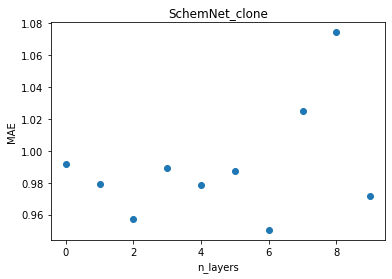

In [76]:
plt.scatter(range(len(loss)-1), loss[1:])
plt.xlabel('n_layers')
plt.ylabel('MAE')
plt.title('SchemNet_clone')
plt.show()